### Layerwise Relevance Propogation

This notebook shows how to perform layerwise relevance propogation on a pretrained CNN network. 

First, load the required libraries.

In [34]:
import tensorflow as tf
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import pickle
import warnings
import os
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")
from glob import glob
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## LayerwiseRelevancePropogation class

This class will do the LRP on a pretrained model. Right now, this class supports:

    * Conv2D, Dense, Add, BatchNormalization, and Pooling layers
    * Multiple branches within the neural network and multiple inputs
   
This uses the LRP-$\gamma$ rule on the layers with weights and tne LRP-$\epsilon$ rule on the layers without weights. The LRP-$\gamma$ rule calculates relevances using:


$R_{j} = \sum_{k}\frac{a_{j} \dot (w^{+}_{jk})}{\sum_{0,j} a_{j} \dot (w^{+}_{jk})}{R_{k}}$ (1)

In Equation (1), $a_{j}$ is the activation of node $j$, $w_{jk}$ is the weight of the connection from node $j$ to $k$, and $w^{+}_{jk} = \min\ [0\ w_{jk}]$. 

The LRP-$\epsilon$ rule for a given layer is:

$R_{j} = \sum_{k}\frac{a_{j} \dot (w_{jk}) + \epsilon}{\sum_{0,j} a_{j} \dot (w_{jk})}{R_{k}}$ (2)

Here $\epsilon$ is a small number, $10^{-10}$ for this case. This helps to reduce the possibility of very small weights backpropogating and therefore causing rounding errors and numerical instability. There are numerous LRP rules that can be used to calculate the relevance. More information about these rules are in Montavon et al. (2019). 

This loop is initalized with the relevances of the output layer set to the predicted values of the outputs. $R_{j}$ is calculated until we reach the input layer where the loop stops.

# References

Montavon, G., A. Binder, S. Lapuschkin, W. Samek, and K.-R. Müller, 2019: Layer-Wise Relevance
Propagation: An Overview, 193–209. Springer International Publishing, Cham, https://doi.org/10.1007/978-3-030-28954-6_10, URL https://doi.org/10.1007/978-3-030-28954-6_10

In [2]:
class LayerwiseRelevancePropogation():
    def __init__(self, model):
        self.model = model
        # Epsilon for epsilon RLP rule
        self.epsilon = 1e-10
        # Count the number of input layers --> Number of CNN networks
        self.no_inputs = 0
        self.pooling_type = "max"
        for x in model.layers:
            if 'input_' in x.name:
                self.no_inputs += 1
        # Alpha = 1 is LRP-gamma, set to < 1 to allow negative weights to backpropogate
        self.alpha = 1
        self.beta = 1 - self.alpha
        
    def backprop_dense(self, x, w, b, r):
        w_pos = tf.maximum(w, 0)
        b_pos = tf.maximum(b, 0)
        w_neg = tf.minimum(w, 0)
        b_neg = tf.minimum(b, 0)
        z = tf.matmul(x, w_pos) + b_pos
        s = r / z
        c_p = tf.matmul(s, tf.transpose(w_pos))
        z = tf.matmul(x, w_neg) + b_neg
        s = r / z
        c_n = tf.matmul(s, tf.transpose(w_neg))
        return (self.alpha * c_p + self.beta * c_n) * x 

    def backprop_flatten(self, x, r):
        return tf.reshape(r, tf.shape(x))
    
    def relprop_add(self, x, r):
        z = tf.add_n(x) + self.epsilon
        s = r / z
        c = s
        return c * x
        
    def relprop_batchnorm(self, x, r, w, b):
        w_pos = tf.maximum(w, 0)
        b_pos = tf.maximum(b, 0)
        w_neg = tf.minimum(w, 0)
        b_neg = tf.minimum(b, 0)
        gamma = w_pos[0]
        beta = w_pos[1]
        mmean = w_pos[2]
        mvar = w_pos[3]
        b_pos = tf.maximum(b, 0)
        z = tf.nn.batch_normalization(x, mmean, mvar, beta, gamma, self.epsilon) + b_pos
        s = r / z
        with tf.GradientTape() as g:
            g.watch(s)
            R = tf.nn.batch_normalization(s, mmean, mvar, beta, gamma, self.epsilon) + b_pos
        c_p = g.gradient(R, s)

        gamma = w_neg[0]
        beta = w_neg[1]
        mmean = w_neg[2]
        mvar = w_neg[3]
        b_neg = tf.minimum(b, 0)
        z = tf.nn.batch_normalization(x, mmean, mvar, beta, gamma, self.epsilon) + b_neg
        s = r / z
        with tf.GradientTape() as g:
            g.watch(s)
            R = tf.nn.batch_normalization(s, mmean, mvar, beta, gamma, self.epsilon) + b_neg
        c_n = g.gradient(R, s)
        return (self.alpha * c_p + self.beta * c_n) * x

    # Conv2D backpropogation 
    def relprop_conv(self, x, r, w, b, strides=(1, 1, 1, 1), padding='SAME'):
        b_pos = tf.maximum(b, 0)
        b_neg = tf.minimum(b, 0)
        if len(strides) == 2:
            strides = (1, strides[0], strides[1], 1)
        w_pos = tf.maximum(w, 0)
        w_neg = tf.minimum(w, 0)
        z = tf.nn.conv2d(x, w_pos, strides, padding) + self.epsilon + b_pos
        s = r / z
        c_p = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_pos, s, strides, padding)

        
        z = tf.nn.conv2d(x, w_neg, strides, padding) + self.epsilon + b_neg
        s = r / z
        c_n = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_neg, s,
                strides, padding)

        return (self.alpha * c_p + self.beta * c_n) * x

    # Maxpooling layer RLP
    def relprop_pool(self, x, r, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME'):
        if len(strides) == 2:
            strides = (1, strides[0], strides[1], 1)
        if len(ksize) == 2:
            ksize = (1, ksize[0], ksize[1], 1)
        if self.pooling_type == 'avg':
            z = tf.nn.avg_pool(x, ksize, strides, padding) + self.epsilon
            s = r / z
            with tf.GradientTape() as g:
                g.watch(s)
                R = tf.nn.avg_pool(s, ksize, strides, padding)
            c = g.gradient(R, s)
        elif self.pooling_type == 'max':
            z = tf.nn.max_pool(x, ksize, strides, padding) + self.epsilon
            s = r / z
            c = tf.raw_ops.MaxPoolGradV2(orig_input=x, orig_output=z, grad=s, ksize=ksize, strides=strides, padding=padding)
        else:
            raise Exception('Error: no such unpooling operation.')
        return c * x

    def calc_relevance(self, inputs, outputs):
        if len(list(inputs.keys())) != self.no_inputs:
            raise InputError("Not enough inputs for model. Need %d inputs" % self.no_inputs)
        cur_layer = self.model.layers[-1]
        cur_relevance = outputs
        output_relevances = {}
        
        output_relevances["output"] = tf.constant(outputs.astype(np.float32))
        # Evaluate x for each layer:
        x_layers = inputs.copy()
        for my_layer in self.model.layers:
            if not isinstance(my_layer.input, list):
                x_layers[my_layer.name.split("/")[0]] = my_layer(x_layers[my_layer.input.name.split("/")[0]])
            else:
                x_layers[my_layer.name.split("/")[0]] = my_layer(list(x_layers[y.name.split("/")[0]] for y in my_layer.input))
                
        x_layers["output"] = tf.constant(outputs.astype(np.float32))
        # Backpropgate relevances
        for my_layer in self.model.layers[-1::-1]:
            if not isinstance(my_layer.input, list):
                inp_layer_name = my_layer.input.name.split("/")[0]
            if 'add' in my_layer.name:
                x_list = [x_layers[g.name.split("/")[0]] for g in my_layer.input]
                out_layer_name = my_layer._outbound_nodes[0].outputs.name.split("/")[0]
                add_relevances = tf.split(self.relprop_add(
                    x_list, output_relevances[out_layer_name]), self.no_inputs, axis=0)
                continue
            

            inp_layer = self.model.get_layer(inp_layer_name)
            try:
                out_layer_name = my_layer._outbound_nodes[0].outputs.name.split("/")[0]
            except IndexError:
                out_layer_name = "output"
            
            if 'dense' in my_layer.name or 'class' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.backprop_dense(
                    x_layers[inp_layer_name],
                    my_layer.trainable_weights[0], my_layer.trainable_weights[1],
                    output_relevances[out_layer_name])
            elif 'conv2d' in my_layer.name:       
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_conv(
                    x_layers[inp_layer_name],
                    output_relevances[out_layer_name],
                    my_layer.trainable_weights[0], my_layer.trainable_weights[1],
                    strides=my_layer.strides, 
                    padding=my_layer.padding.upper())
            elif 'batch_normalization' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_batchnorm(
                        x_layers[inp_layer_name], 
                        output_relevances[out_layer_name],
                        my_layer.trainable_weights[0], my_layer.trainable_weights[1])
            elif 'flatten' in my_layer.name:
                name = my_layer.name.split("/")[0]
                if name[-1] == "n":
                    count = 0
                else:
                    count = int(name.split("_")[1])
                output_relevances[my_layer.name.split("/")[0]] = self.backprop_flatten(
                    x_layers[inp_layer_name],
                    add_relevances[count])
            elif 'max_pooling2d' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_pool(
                    x_layers[inp_layer_name],
                    output_relevances[out_layer_name], my_layer.pool_size,
                    my_layer.strides, my_layer.padding.upper())
            elif 'input' in my_layer.name:
                output_relevances[my_layer.name] = output_relevances[out_layer_name]
            
        return output_relevances

# Loading the input model

Here, we load the input model that we are going to perform the relevance calculations on. We will use the EPA AQI classifier model from earlier on in order to do so. The
*hour* variable specified how far in the future we are predicting.

In [3]:
my_model = tf.keras.models.load_model(
        '/lcrc/group/earthscience/rjackson/opencrums/models/classifier-hou-lag-2class-surface-mass-only-0')

2023-06-21 13:38:08.141547: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 13:38:08.674380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37755 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


## Load the input data

First, load the EPA AirNow PM2.5 indicies for Houston.

In [4]:
air_now_data = glob('/lcrc/group/earthscience/rjackson/epa_air_now/*.csv')
air_now_df = pd.concat(map(pd.read_csv, air_now_data))
air_now_df['datetime'] = pd.to_datetime(air_now_df['DateObserved'] + ' 00:00:00')
air_now_df = air_now_df.set_index('datetime')
air_now_df = air_now_df[air_now_df['ParameterName'] == "PM2.5"]
air_now_df = air_now_df.sort_index()

The below code maps the EPA AirNow PM2.5 index to a specific MERRA2 time period. All values > 2 (Moderate) are excluded since we only trained the model to make predictions for Good and Moderate conditions.

In [5]:
def get_air_now_label(time):
    if np.min(np.abs((air_now_df.index - time))) > timedelta(days=1):
        return np.nan
    ind = np.argmin(np.abs(air_now_df.index - time))
    cat_number = air_now_df['CategoryNumber'].values[ind]
    if cat_number > 2:
        cat_number = np.nan
    return cat_number

Then, load the MERRA2 data. 

In [6]:
lat_slice = slice(25, 35)
lon_slice = slice(-100, -90)
# Load MERRA2 data from files
def load_data(species):
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/%sSMASS*.nc' % species,
            parallel=True)
    print(ds)
    times = np.array(list(map(pd.to_datetime, ds.time.values)))
    try:
        x = ds["%sSMASS25" % species].values
    except KeyError:
        x = ds["%sSMASS" % species].values
    lat = ds["lat"].values
    lon = ds["lon"].values
    old_shape = x.shape
    scaler = StandardScaler()
    scaler.fit(np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = scaler.transform(
            np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = np.reshape(x, old_shape)
    classification = np.array(list(map(get_air_now_label, times)))
    where_valid = np.isfinite(classification)
    x = x[where_valid, :, :]
    classification = classification[where_valid] - 1
    times = times[where_valid]
    print(times.shape, classification.shape)
    y = np.concatenate([tf.one_hot(classification, 2).numpy(), times[:, np.newaxis]], axis=1)
    x_dataset_train = {'input_%sSMASS' % species: x}

    return x_dataset_train, y[:,:2], y[:,2]

x_ds_train = {}
x_ds_test = {}
y_train = []
y_test = []
species_list = ['SS', 'SO4', 'OC','DU', 'BC']
for species in species_list:
    x_ds_train1, y_train, t_train = load_data(species)
    x_ds_train.update(x_ds_train1)

<xarray.Dataset>
Dimensions:    (lon: 17, lat: 21, time: 113952)
Coordinates:
  * lon        (lon) float64 -100.0 -99.38 -98.75 -98.12 ... -91.25 -90.62 -90.0
  * lat        (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.5 34.0 34.5 35.0
  * time       (time) datetime64[ns] 2010-01-01T00:30:00 ... 2022-12-31T23:30:00
Data variables:
    SSSMASS    (time, lat, lon) float32 dask.array<chunksize=(8760, 21, 17), meta=np.ndarray>
    SSSMASS25  (time, lat, lon) float32 dask.array<chunksize=(8760, 21, 17), meta=np.ndarray>
(97056,) (97056,)
<xarray.Dataset>
Dimensions:   (lon: 17, lat: 21, time: 113952)
Coordinates:
  * lon       (lon) float64 -100.0 -99.38 -98.75 -98.12 ... -91.25 -90.62 -90.0
  * lat       (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.5 34.0 34.5 35.0
  * time      (time) datetime64[ns] 2010-01-01T00:30:00 ... 2022-12-31T23:30:00
Data variables:
    SO4SMASS  (time, lat, lon) float32 dask.array<chunksize=(8760, 21, 17), meta=np.ndarray>
(97056,) (97056,)
<xarray.Dataset>
Di

## Generate model predictions

Use the keras .predict to generate predictions on a set of test data.

In [7]:
y_predict = my_model.predict(x_ds_train)

2023-06-21 13:42:16.059482: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-06-21 13:42:23.033877: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-21 13:42:24.026726: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Generate all of the relevances

These next two code blocks will generate the relevance information. The relevance dictionaries are stored in pickle files that contain the dictionary of relevances for each of the input variables and model layers as well as the time of each sample.

In [15]:
def slice_input_ds(x: dict, y, t, start, end):
    x_new = {}
    for key in x.keys():
        x_new[key] = x[key][start:end, :, :, np.newaxis].copy()
    y_new = y[start:end, :].copy()
    t_test = t[start:end].copy()
    return x_new, y_new, t_test

Run the LRP for each time period, then normalize each result by the maximum relevance to have a scale from -1 to 1 for relevance. Write results to a netCDF file.

In [ ]:
ds = xr.open_dataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/DUCMASS2010.nc').sortby('time')
lat = ds.lat.values
lon = ds.lon.values
num_times = 100
rel_out = 'relevances'
lrp = LayerwiseRelevancePropogation(my_model)
for i in range(0, y_predict.shape[0], num_times):
    print(i + num_times)
    x_slice, y_slice, t_slice = slice_input_ds(x_ds_train, y_predict, t_train, i, i + num_times)
    relevance = lrp.calc_relevance(x_slice, y_slice)
    out_ds = {}
    out_ds['time'] = xr.DataArray(t_slice, dims=['time'])
    out_ds['aqi'] = xr.DataArray(y_slice.argmax(axis=1), dims=['time'])
    means = []
    for key in relevance.keys():
        if "input_" in key:
            arr = relevance[key].numpy()

            times = out_ds["time"]
            ind_sort = np.argsort(times)
            arr = arr[ind_sort, 1:-1, 1:-1, :]
            times = times[ind_sort]
            out_ds["rel_" + key[6:]] = xr.DataArray(
                    np.squeeze(arr), dims=('time', 'lat', 'lon'))
            
    for j in range(num_times):
        if i + j >= y_predict.shape[0]:
            continue
        relevance_arr = []
        for key in relevance.keys():
            if "input_" in key:
                relevance_arr.append(out_ds["rel_" + key[6:]].values[j, :, :].flatten())
        # If we have NaNs, RLP is failing, we can't make a decision
        relevance_arr = np.stack(relevance_arr)
        rel_max = np.max(relevance_arr)
        if np.isnan(rel_max):
            print("NaNs detected skipping %d" % j)
            continue

        for key in relevance.keys():
            if "input_" in key:
                #cdf = interp1d(bins[1:], cdfs, fill_value=(0, 1), bounds_error=False)
                out_ds["rel_" + key[6:]][j] = out_ds["rel_" + key[6:]][j] / rel_max
                # Check for numerical instability

    relevance_arr = np.concatenate(relevance_arr)
    out_ds['time'] = times[ind_sort]
    labels = relevance['output'].numpy().argmax(axis=1)
    labels = labels[np.array(ind_sort)]
    out_ds['label'] = ('time', labels)
    out_ds['lat'] = ('lat', np.squeeze(lat[1:-1]))
    out_ds['lon'] = ('lon', np.squeeze(lon[1:-1]))
    out_ds = xr.Dataset(out_ds)
    out_ds.to_netcdf(os.path.join(rel_out, 'relevance%d.nc' % i))
 
out_ds = xr.open_mfdataset(rel_out + "/*.nc")
out_ds.to_netcdf('relevances_mass_only.nc')

## Visualizing the results

Let's see if our LRP outputs make sense. To do this, we will plot an example time period where relevances are overlaid over surface mass concentrations to see if the AI and LRP are recognizing features of interest.

In [36]:
OCMASS = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/OCSMASS*.nc').reindex(time=out_ds.time, method='nearest')["OCSMASS"]
BCMASS = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/BCSMASS*.nc').reindex(time=out_ds.time, method='nearest')["BCSMASS"]
SO4MASS = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/SO4SMASS*.nc').reindex(time=out_ds.time, method='nearest')["SO4SMASS"]
DUCMASS = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/DUSMASS*.nc').reindex(time=out_ds.time, method='nearest')["DUSMASS25"]
SSMASS = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/SSSMASS*.nc').reindex(time=out_ds.time, method='nearest')["SSSMASS25"]

Let's load the MERRA2 column flux variables to see the direction and magnitude of the column-wide fluxes. This provides us with an idea of horizontal transport for the whole column for the given time period. Multiply by 1000 to convert from $kg\ m^{-1}\ s^{-1}$ to $g\ m^{-1}\ s^{-1}$. We also multiply the surface mass concentrations by $10^{-9}$ to express them in $\mu g\ m^{-3}$ These both provide us with more easily understandable results that are based around numbers 1-1000.

In [39]:
OCFLUXU = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/OCFLUXU*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
BCFLUXU = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/BCFLUXU*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
SUFLUXU = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/SUFLUXU*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
DUFLUXU = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/DUFLUXU*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
SSFLUXU = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/SSFLUXU*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
OCFLUXV = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/OCFLUXV*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
BCFLUXV = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/BCFLUXV*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
SUFLUXV = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/SUFLUXV*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
DUFLUXV = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/DUFLUXV*.nc').reindex(time=out_ds.time, method='nearest') * 1e3
SSFLUXV = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_extended/SSFLUXV*.nc').reindex(time=out_ds.time, method='nearest') * 1e3

Let's plot for a time period during the TRacking Aerosol Convection intERactions (TRACER) experiment where a transition from sulfate dominated aerosol conditions to organic carbon-dominated aerosol conditions occurred in early September 2022. We plot the surface mass concentrations for these time periods, overlaid with the normalized relevances given in the contours. We divide the data by first and second week of September 2022.

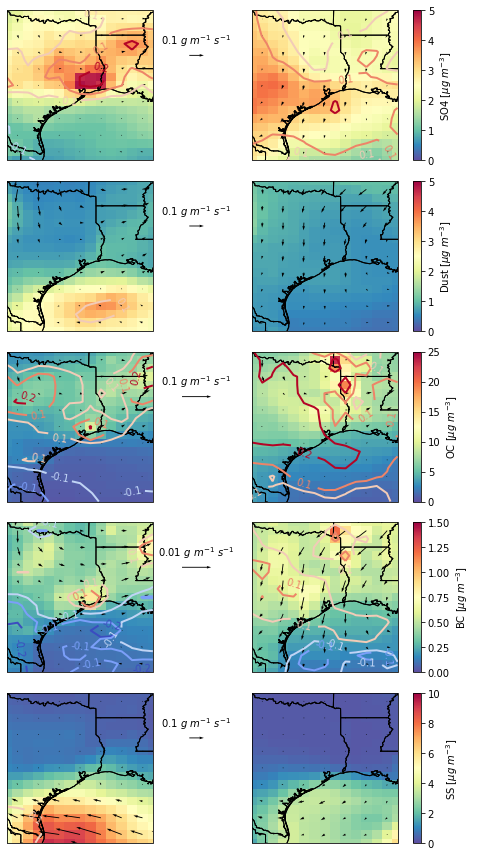

In [40]:
relevances = out_ds
lat = relevances.lat.values
lon = relevances.lon.values
lon, lat = np.meshgrid(OCMASS.lon, OCMASS.lat)
fig, ax = plt.subplots(5, 2, figsize=(8, 12),
                       subplot_kw=dict(projection=ccrs.PlateCarree()))
(SO4MASS.sel(time=slice('2022-09-01', '2022-09-07'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[0, 0], vmin=0, vmax=5, add_colorbar=False, cmap='Spectral_r')
c = relevances["rel_SO4SMASS"].sel(time=slice('2022-09-01', '2022-09-07')).mean(dim='time').plot.contour(
    ax=ax[0, 0], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[0, 0].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[0, 0].quiver(lon[::2, ::2], lat[::2, ::2], 
               SUFLUXU["SUFLUXU"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2],
               SUFLUXV["SUFLUXV"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2], scale=1)

ax[0, 0].quiverkey(q, 1.3, 0.7, 0.1, '$0.1\ g\ m^{-1}\ s^{-1}$')
(DUCMASS.sel(time=slice('2022-09-01', '2022-09-07'))*1e9).mean(dim='time').plot.pcolormesh(ax=ax[1, 0], vmin=0, cmap='Spectral_r',
                                                                                           vmax=5, add_colorbar=False)
c = relevances["rel_DUSMASS"].sel(time=slice('2022-09-01', '2022-09-07')).mean(dim='time').plot.contour(
    ax=ax[1, 0], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[1, 0].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[1, 0].quiver(lon[::2, ::2], lat[::2, ::2], 
               DUFLUXU["DUFLUXU"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2],
               DUFLUXV["DUFLUXV"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2], scale=1)

ax[1, 0].quiverkey(q, 1.3, 0.7, 0.1, '$0.1\ g\ m^{-1}\ s^{-1}$')
(OCMASS.sel(time=slice('2022-09-01', '2022-09-07'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[2, 0], cmap='Spectral_r', vmin=0, vmax=25, add_colorbar=False)
c = relevances["rel_OCSMASS"].sel(time=slice('2022-09-01', '2022-09-07')).mean(dim='time').plot.contour(
    ax=ax[2, 0], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[2, 0].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[2, 0].quiver(lon[::2, ::2], lat[::2, ::2], 
               OCFLUXU["OCFLUXU"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2],
               OCFLUXV["OCFLUXV"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2], scale=0.5)

ax[2, 0].quiverkey(q, 1.3, 0.7, 0.1, '$0.1\ g\ m^{-1}\ s^{-1}$')
(BCMASS.sel(time=slice('2022-09-01', '2022-09-07'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[3, 0], cmap='Spectral_r', vmin=0, vmax=1.5, add_colorbar=False)
c = relevances["rel_BCSMASS"].sel(time=slice('2022-09-01', '2022-09-07')).mean(dim='time').plot.contour(
    ax=ax[3, 0], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[3, 0].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[3, 0].quiver(lon[::2, ::2], lat[::2, ::2], 
               BCFLUXU["BCFLUXU"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2],
               BCFLUXV["BCFLUXV"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2], scale=0.05)

ax[3, 0].quiverkey(q, 1.3, 0.7, 0.01, '$0.01\ g\ m^{-1}\ s^{-1}$')
(SSMASS.sel(time=slice('2022-09-01', '2022-09-07'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[4, 0], cmap='Spectral_r', vmin=0, vmax=10, add_colorbar=False)
c = relevances["rel_SSSMASS"].sel(time=slice('2022-09-01', '2022-09-07')).mean(dim='time').plot.contour(
    ax=ax[4, 0], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[4, 0].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[4, 0].quiver(lon[::2, ::2], lat[::2, ::2], 
               SSFLUXU["SSFLUXU"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2],
               SSFLUXV["SSFLUXV"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2], scale=1)

ax[4, 0].quiverkey(q, 1.3, 0.7, 0.1, '$0.1\ g\ m^{-1}\ s^{-1}$')
(SO4MASS.sel(time=slice('2022-09-08', '2022-09-15'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[0, 1], vmin=0, vmax=5, cmap='Spectral_r', cbar_kwargs=dict(label="SO4 [$\mu g\ m^{-3}$]"))
q = ax[0, 1].quiver(lon[::2, ::2], lat[::2, ::2], 
               SUFLUXU["SUFLUXU"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2],
               SUFLUXV["SUFLUXV"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2], scale=1)
                                                                                      
c = relevances["rel_SO4SMASS"].sel(time=slice('2022-09-08', '2022-09-15')).mean(dim='time').plot.contour(
    ax=ax[0, 1], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[0, 1].clabel(c, c.levels[:], fmt="%2.1f")
(DUCMASS.sel(time=slice('2022-09-08', '2022-09-15'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[1, 1], vmin=0, vmax=5, cmap='Spectral_r', cbar_kwargs=dict(label="Dust [$\mu g\ m^{-3}$]"))
q = ax[1, 1].quiver(lon[::2, ::2], lat[::2, ::2], 
               DUFLUXU["DUFLUXU"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2],
               DUFLUXV["DUFLUXV"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2], scale=1)
                                                                                        
c = relevances["rel_DUSMASS"].sel(time=slice('2022-09-07', '2022-09-15')).mean(dim='time').plot.contour(
    ax=ax[1, 1], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[1, 1].clabel(c, c.levels[:], fmt="%2.1f")
(OCMASS.sel(time=slice('2022-09-08', '2022-09-15'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[2, 1], vmin=0, vmax=25, cmap='Spectral_r', cbar_kwargs=dict(label="OC [$\mu g\ m^{-3}$]"))
q = ax[2, 1].quiver(lon[::2, ::2], lat[::2, ::2], 
               OCFLUXU["OCFLUXU"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2],
               OCFLUXV["OCFLUXV"].sel(time=slice('2022-09-01', '2022-09-07')).median(dim='time').values[::2, ::2], scale=0.5)
                                                                                
c = relevances["rel_OCSMASS"].sel(time=slice('2022-09-08', '2022-09-15')).mean(dim='time').plot.contour(
    ax=ax[2, 1], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[2, 1].clabel(c, c.levels[:], fmt="%2.1f")
(BCMASS.sel(time=slice('2022-09-08', '2022-09-15'))*1e9).mean(dim='time').plot.pcolormesh(
    ax=ax[3, 1], vmin=0, vmax=1.5, cmap='Spectral_r', cbar_kwargs=dict(label="BC [$\mu g\ m^{-3}$]"))
c = relevances["rel_BCSMASS"].sel(time=slice('2022-09-08', '2022-09-15')).mean(dim='time').plot.contour(
    ax=ax[3, 1], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[3, 1].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[3, 1].quiver(lon[::2, ::2], lat[::2, ::2], 
               BCFLUXU["BCFLUXU"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2],
               BCFLUXV["BCFLUXV"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2], scale=0.05)

(SSMASS.sel(time=slice('2022-09-08', '2022-09-15'))*1e9).mean(dim='time').plot.pcolormesh(ax=ax[4, 1], vmin=0, vmax=10, cmap='Spectral_r',                                                                                     cbar_kwargs=dict(label="SS [$\mu g\ m^{-3}$]"))
c = relevances["rel_SSSMASS"].sel(time=slice('2022-09-07', '2022-09-15')).mean(dim='time').plot.contour(
    ax=ax[4, 1], levels=[-0.2, -0.1, -0.05, 0.05, 0.1, 0.2], cmap='coolwarm', linewidths=[2])
ax[4, 1].clabel(c, c.levels[:], fmt="%2.1f")
q = ax[4, 1].quiver(lon[::2, ::2], lat[::2, ::2], 
               SSFLUXU["SSFLUXU"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2],
               SSFLUXV["SSFLUXV"].sel(time=slice('2022-09-08', '2022-09-15')).median(dim='time').values[::2, ::2], scale=1)


for i in range(5):
    for j in range(2):
        ax[i, j].set_xlim([OCMASS.lon[1], OCMASS.lon[-2]])
        ax[i, j].set_ylim([OCMASS.lat[1], OCMASS.lat[-2]])
        ax[i, j].add_feature(cfeature.STATES)
        ax[i, j].coastlines()
fig.tight_layout()

As we can see, LRP is determining a region of enhanced sulfate mass concentrations in Southeast Texas for the first week of September 2022 on the left. In addition, LRP is placing normalized relevances of greater than 0.1 for Organc Carbon over Houston, and 0.2 for the OC-dominated period for the second week of September. The AI especially focuses on the elevated organics over central Texas as well as over isolated regions near Texarkana that could be a result of local emissions.

LRP is also placing normalized relevances greater than 0.1 of Black Carbon in a region between Houston and Beaumont for early September and over east Central Texas for the second week of September. The flux arrows indicate for both of these time periods we are not observing flow of sea salt from the Gulf and dust from inland. This therefore suggests that the aerosols are more likely of continental origin than marine for both time periods. The larger magnitudes of the fluxes offshore in the second week suggest stronger offshore flow, preventing sea salt from being an important predictor of the PM2.5 index for this time period.  

Therefore, for these two weeks, it appears that the LRP technique is providing relevances that are consistent with aerosol transport that is occurring over the region.